<a href="https://colab.research.google.com/github/Thikkar/music-generator/blob/main/PoemsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Set-up

1.1 Scripts

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir  ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d michaelarman/poemsdataset

 77% 12.0M/15.5M [00:00<00:00, 21.6MB/s]
100% 15.5M/15.5M [00:00<00:00, 25.4MB/s]


In [ ]:
! unzip poemsdataset.zip > out.txt

error:  cannot create topics/racism/RacismPoemsTranslationOfRacismIsAroundMeEverywhereByFrancisDugganржЖржорж░ржЪрж░ржкрж╢ржЫрзЬрзЯржЖржЫржЬрждржмржжржмрж╖ржорж▓ржлрж░ржирж╕рж╕ржбржЧржиPoembyAlamSayed.txt
        File name too long


1.2 Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

## 2. Data Pre-processing

2.1 a) Load Pre-Processed Data

In [ ]:
poems_classifier_df = pd.read_csv("/content/poemsdataset-original.csv")
poems_classifier_df.drop("Unnamed: 0", axis=1, inplace=True)
poems_classifier_df

,poem,label
0,varus drag affair forum see idle little whore ...,girl
1,pretty walk witty talk pleasant think sir john...,girl
2,world weary girl tear form eye confusion swirl...,girl
3,little girl little curl right middle forehead ...,girl
4,thank friend rare positive care like sister wo...,girl
...,...,...
14329,remember nation born war purpose establish fre...,war
14330,course human event choose go war choose intere...,war
14331,rationale go war turn false claim would go war...,war
14332,look across land see sight grand scene eerie s...,war


2.1 b) OR... Load Data from Scratch

In [ ]:
# Load data into pandas dataframe - [1 sec]
data = []

for root, dirs, files in os.walk("/content/topics"):
    label = os.path.basename(root)
    
    for file in files:
      path = root + '/' + file
      poem = []
      with open(path) as f:
        poem = f.readlines()

      poem_text = ''.join(poem)
      pair = (poem_text, label)
      data.append(pair)

poems_df = pd.DataFrame(data, columns=['poem', 'label'])
poems_df

,poem,label
0,Varus drags me into his affairs\nout of the Fo...,girl
1,"""She's pretty to walk with,\nAnd witty to talk...",girl
2,"World-weary girl,\nTears form in your eyes,\nC...",girl
3,"There was a little girl,\nWho had a little cur...",girl
4,Thank you--she is my friend\nIt's a rare posit...,girl
...,...,...
14329,"Remembered\nA nation born from war, for the “p...",war
14330,"When in the course of human events, we choose ...",war
14331,When your rationale for going to war\nturns ou...,war
14332,"Looking out across the land,\nI see a sight th...",war


2.2 Text Cleaning and Simplification

In [ ]:
# Text cleaning (Lemmatization, Stemming, Stop Words, Punctuation) - [10 mins]
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb
poems_classifier_df = poems_df
for idx in range(len(poems_classifier_df.poem)): 
    poem_clean = poems_classifier_df.poem[idx]

    poem_clean = re.split('\W+', poem_clean.lower())
    poem_clean = [w for w in poem_clean if not w in set(stopwords.words('english'))]  # Remove stopwords
    
    lem = WordNetLemmatizer()
    poem_clean = [lem.lemmatize(w, get_wordnet_pos(w)) for w in poem_clean if len(w) > 1]
    
    poem_clean = ' '.join(poem_clean)
    poems_classifier_df.poem[idx] = poem_clean

poems_classifier_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,poem,label
0,varus drag affair forum see idle little whore ...,girl
1,pretty walk witty talk pleasant think sir john...,girl
2,world weary girl tear form eye confusion swirl...,girl
3,little girl little curl right middle forehead ...,girl
4,thank friend rare positive care like sister wo...,girl
...,...,...
14329,remember nation born war purpose establish fre...,war
14330,course human event choose go war choose intere...,war
14331,rationale go war turn false claim would go war...,war
14332,look across land see sight grand scene eerie s...,war


In [ ]:
# Re-map each label

categories_dictionary = {
  "alone": "sad",
  "america": "location",
  "angel": "religious",
  "anger": "evil",
  "animal": "animal",
  "baby": "family",
  "beach": "nature",
  "beautiful": "love",
  "beauty": "love",
  "believe": "inspirational",
  "birth": "happy",
  "brother": "family",
  "butterfly": "animal",
  "car": "object",
  "carpe diem": "inspirational",
  "change": "unknown",
  "chicago": "location",
  "childhood": "unknown",
  "children": "family",
  "christmas": "happy",
  "cinderella": "unknown",
  "city": "location",
  "courage": "inspirational",
  "crazy": "evil",
  "culture": "unknown",
  "dance": "activity",
  "dark": "sad",
  "daughter": "family",
  "death": "sad",
  "depression": "sad",
  "despair": "sad",
  "destiny": "inspirational",
  "dream": "inspirational",
  "evil": "evil",
  "faith": "religious",
  "family": "family",
  "father": "family",
  "fear": "evil",
  "fire": "unknown",
  "food": "object",
  "football": "object",
  "freedom": "inspirational",
  "friend": "family",
  "frog": "animal",
  "funeral": "sad",
  "funny": "happy",
  "future": "unknown",
  "girl": "unknown",
  "god": "religious",
  "graduation": "unknown",
  "greed": "evil",
  "green": "object",
  "hair": "object",
  "happiness": "happy",
  "happy": "happy",
  "hate": "evil",
  "heaven": "happy",
  "hero": "inspirational",
  "home": "family",
  "hope": "inspirational",
  "house": "family",
  "hunting": "activity",
  "husband": "family",
  "identity": "unknown",
  "innocence": "unknown",
  "january": "unknown",
  "joy": "happy",
  "june": "unknown",
  "justice": "inspirational",
  "kiss": "love",
  "laughter": "happy",
  "life": "introspection",
  "lonely": "sad",
  "loss": "sad",
  "lost": "sad",
  "love": "love",
  "lust": "evil",
  "marriage": "love",
  "memory": "introspection",
  "mirror": "object",
  "money": "object",
  "moon": "object",
  "mother": "family",
  "murder": "evil",
  "music": "unknown",
  "nature": "nature",
  "night": "unknown",
  "ocean": "nature",
  "paris": "location",
  "passion": "love",
  "peace": "happy",
  "pink": "object",
  "poem": "unknown",
  "poetry": "unknown",
  "poverty": "sad",
  "power": "unknown",
  "racism": "evil",
  "rain": "nature",
  "rainbow": "happy",
  "red": "object",
  "remember": "introspection",
  "respect": "love",
  "river": "nature",
  "romance": "love",
  "romantic": "love",
  "rose": "love",
  "running": "activity",
  "school": "activity",
  "sea": "nature",
  "sick": "sad",
  "silver": "object",
  "sister": "family",
  "sky": "nature",
  "sleep": "activity",
  "snake": "unknown",
  "soldier": "unknown",
  "sometimes": "unknown",
  "son": "family",
  "song": "unknown",
  "sorrow": "sad",
  "spring": "nature",
  "star": "nature",
  "success": "inspirational",
  "suicide": "sad",
  "summer": "nature",
  "sun": "nature",
  "swimming": "activity",
  "sympathy": "sad",
  "teacher": "activity",
  "thanks": "happy",
  "time": "introspection",
  "today": "unknown",
  "together": "love",
  "travel": "activity",
  "trust": "love",
  "truth": "unknown",
  "unknown": "unknown",
  "war": "evil",
  "warning": "evil",
  "water": "object",
  "weather": "nature",
  "wedding": "love",
  "winter": "nature",
  "work": "activity",
  "world": "unknown",
}

In [ ]:
# Replace labels
for idx, label in enumerate(poems_classifier_df.label):
  if label in categories_dictionary:
    poems_classifier_df.label[idx] = categories_dictionary[label]

# Drop miscellaneous poems
drop_labels = ["unknown", "object", "animal", "location", "religious", "introspection", "activity"]
for label in drop_labels:
  poems_classifier_df = poems_classifier_df[poems_classifier_df.label != label]

poems_classifier_df

,poem,label
100,slant sun dull brown wall forgotten sky bashfu...,nature
101,hast thou charm stay morning star steep course...,nature
102,sun generous dad love bask bright true moon se...,nature
103,sometimes mortal feel nature father mother sti...,nature
104,sun go shin debbil beat wife blue played lefth...,nature
...,...,...
14329,remember nation born war purpose establish fre...,evil
14330,course human event choose go war choose intere...,evil
14331,rationale go war turn false claim would go war...,evil
14332,look across land see sight grand scene eerie s...,evil


2.3 EDA

Text(0.5, 1.0, 'Frequency Distribution of Labels')

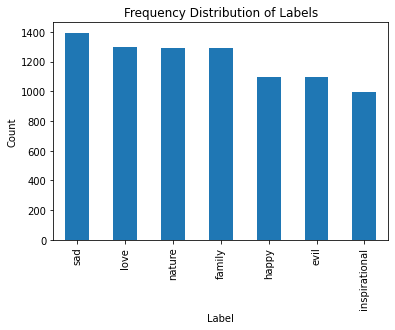

In [ ]:
# Frequency Distribution of labels

fig, ax = plt.subplots()
poems_classifier_df['label'].value_counts().plot(ax=ax, kind='bar')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Frequency Distribution of Labels")

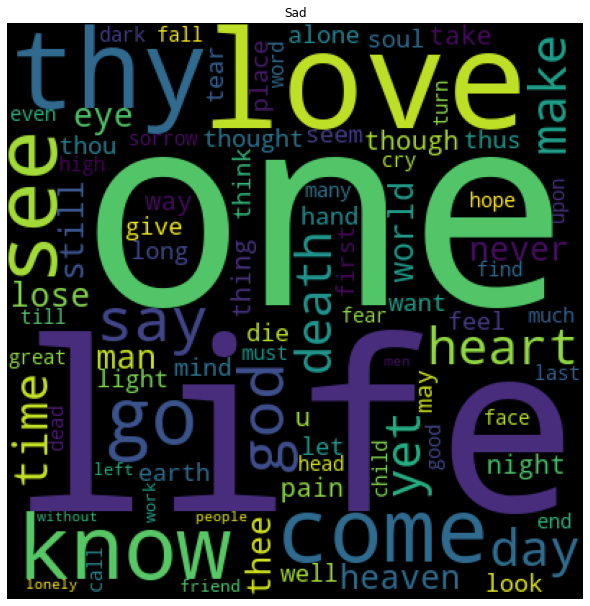

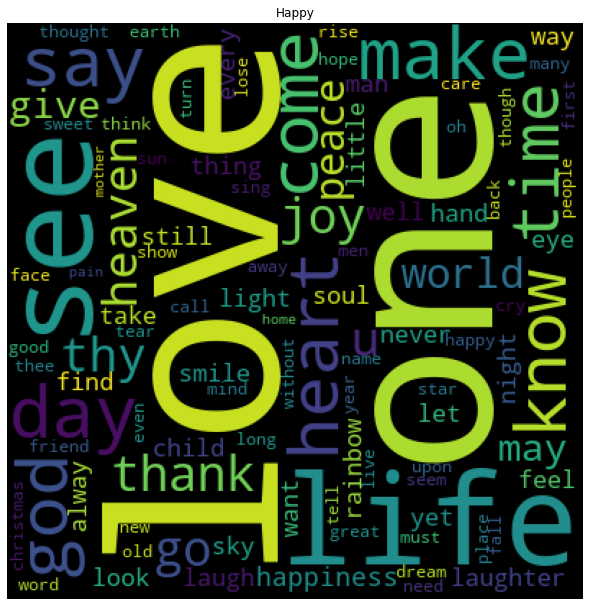

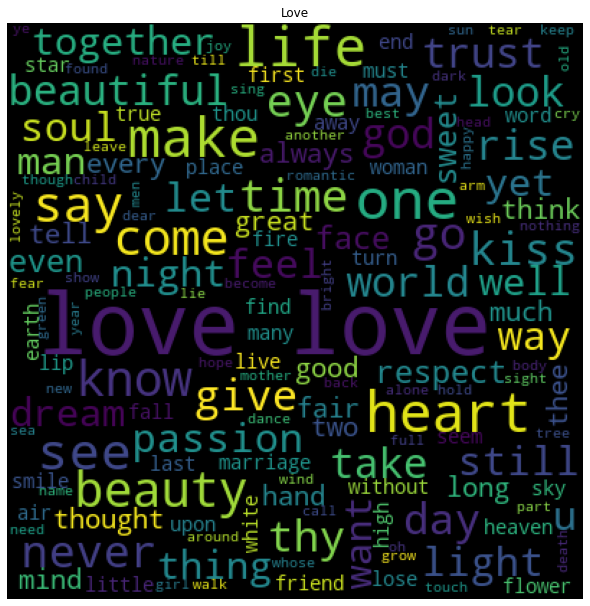

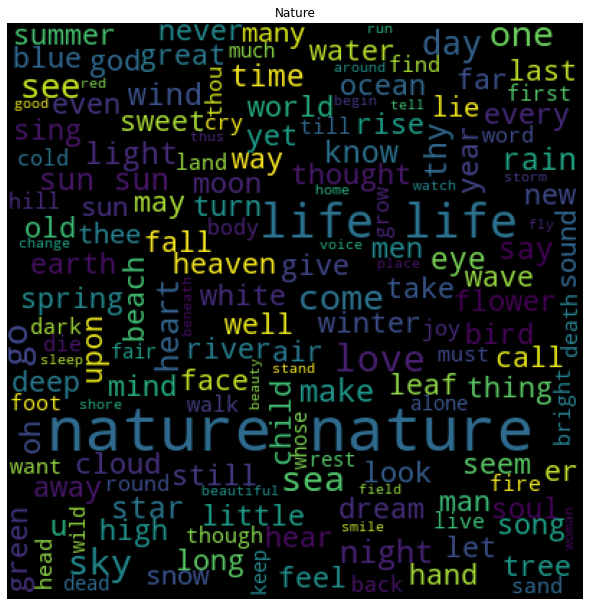

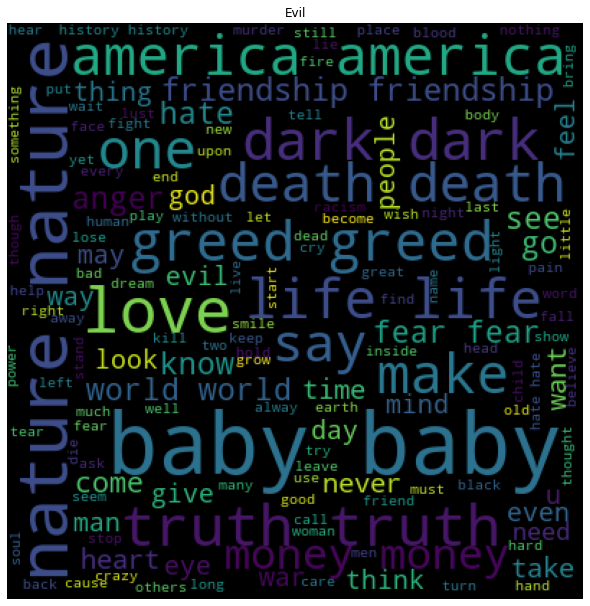

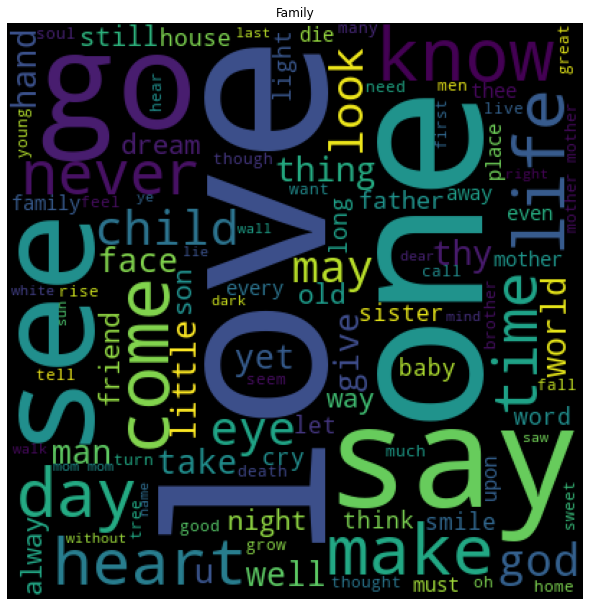

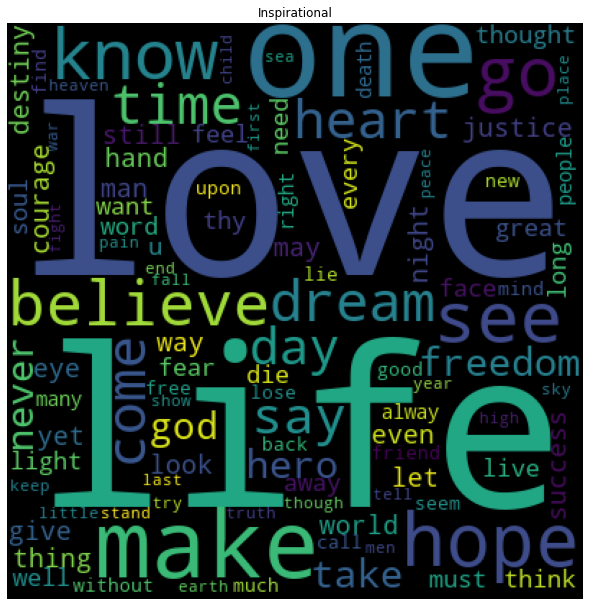

In [ ]:
# Generate Word Clouds for classes of poems - [15 sec]

sad_words = ""
happy_words = ""
love_words = ""
nature_words = ""
evil_words = ""
family_words = ""
inspirational_words = ""

for idx, row in poems_classifier_df.iterrows():
  poem, label = str(row["poem"]), str(row["label"])
  if label == "sad":
    sad_words += poem + " "
  if label == "happy":
    happy_words += poem + " " 
  if label == "love":
    love_words += poem + " "
  if label == "nature":
    nature_words += poem + " "
  if label == "evil":
    evil_words += poem + " "
  if label == "family":
    family_words += poem + " "
  if label == "inspirational":
    inspirational_words += poem + " "

def generate_wordcloud(words):
  wordcloud_dim, wordcloud_color = 400, 'black'
  # stopwords = ["love", "one", "life", "like"]

  return WordCloud(width = wordcloud_dim, height = wordcloud_dim,
                background_color = wordcloud_color,
                # stopwords=stopwords,
                min_font_size = 10).generate(words)

sad_wordcloud = generate_wordcloud(sad_words)
happy_wordcloud = generate_wordcloud(happy_words)
love_wordcloud = generate_wordcloud(love_words)
nature_wordcloud = generate_wordcloud(nature_words)
evil_wordcloud = generate_wordcloud(evil_words)
family_wordcloud = generate_wordcloud(family_words)
inspirational_wordcloud = generate_wordcloud(inspirational_words)

wordclouds = {"Sad": sad_wordcloud, 
              "Happy": happy_wordcloud, 
              "Love": love_wordcloud,
              "Nature": nature_wordcloud, 
              "Evil": evil_wordcloud,
              "Family": family_wordcloud,
              "Inspirational": inspirational_wordcloud}

for label, wordcloud in wordclouds.items():
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.title(label)
  
  plt.show()

2.4 Input/Output Encoding

In [ ]:
# Label Encoder - [1 sec]
enc = LabelEncoder()
poems_classifier_df["label_encoded"] = enc.fit_transform( poems_classifier_df["label"] )

print(f"Encodings: {list(zip(range(0,7), enc.classes_))}\n")

# TF-IDF - [2 sec]
X, y = poems_classifier_df["poem"].values.astype("U"), poems_classifier_df["label_encoded"].values

vectorizer = TfidfVectorizer(max_features=1500)
X_vectorized = vectorizer.fit_transform(X).toarray()

poems_classifier_df

Encodings: [(0, 'evil'), (1, 'family'), (2, 'happy'), (3, 'inspirational'), (4, 'love'), (5, 'nature'), (6, 'sad')]



,Unnamed: 0,poem,label,label_encoded
100,100,slant sun dull brown wall forgotten sky bashfu...,nature,5
101,101,hast thou charm stay morning star steep course...,nature,5
102,102,sun generous dad love bask bright true moon se...,nature,5
103,103,sometimes mortal feel nature father mother sti...,nature,5
104,104,sun go shin debbil beat wife blue played lefth...,nature,5
...,...,...,...,...
14329,14329,remember nation born war purpose establish fre...,evil,0
14330,14330,course human event choose go war choose intere...,evil,0
14331,14331,rationale go war turn false claim would go war...,evil,0
14332,14332,look across land see sight grand scene eerie s...,evil,0


2.5 Train/Test Split

In [ ]:
# Train/Test Split - [3 sec]
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, stratify=y, random_state=0)

## 3. Models

3.1 Naive Bayes (Poems Classifier)

[1 3 5 ... 5 5 4]
[1 3 5 ... 5 2 4]

 Accuracy:  0.6252955082742316

 Accuracy:  0.7017880892566869

Classification Report

               precision    recall  f1-score   support

           0       0.72      0.61      0.66       219
           1       0.61      0.67      0.64       258
           2       0.74      0.45      0.56       220
           3       0.82      0.57      0.67       199
           4       0.67      0.58      0.62       259
           5       0.53      0.79      0.64       258
           6       0.54      0.67      0.60       279

    accuracy                           0.63      1692
   macro avg       0.66      0.62      0.63      1692
weighted avg       0.65      0.63      0.62      1692



Text(33.0, 0.5, 'Predicted label')

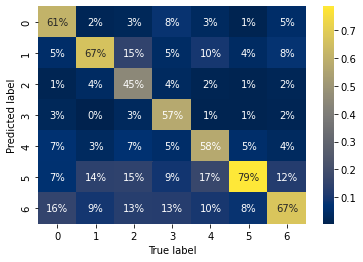

In [ ]:
# train classifier
classifier = MultinomialNB(alpha=1)
classifier.fit(X_train, y_train)

# predict
y_pred = classifier.predict(X_test)

# report
classification_report = classification_report(y_test, y_pred)

print('\n Accuracy: ', accuracy_score(y_test, y_pred))
print('\n Accuracy: ', accuracy_score(y_train, y_pred_2))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)

conf_mat = confusion_matrix(y_test, y_pred, normalize = "true")
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis", xticklabels=[0,1,2,3,4,5,6], yticklabels=[0,1,2,3,4,5,6])
plt.xlabel("True label")
plt.ylabel("Predicted label")

## 4. Notes

In [ ]:
with open("/content/topics/marriage/MarriagePoemsMarriageSongPoembyYehudahHaLevi.txt") as f:
  lines = f.readlines()

print(lines)

['Fair is my dove, my loved one,\n', 'None can with her compare:\n', 'Yea, comely as Jerusalem,\n', 'Like unto Tirzah fair.\n', 'Shall she in tents unstable\n', 'A wanderer abide,\n', 'While in my heart awaits her\n', 'A dwelling deep and wide?\n', 'The magic of her beauty\n', 'Has stolen my heart away:\n', "Not Egypt's wise enchanters\n", 'Held half such wondrous sway.\n', 'Even as the changing opal\n', 'In varying luster glows,\n', 'Her face at every moment\n', 'New charms and sweetness shows.\n', 'White lilies and red roses\n', 'There blossom on one stem:\n', 'Her lips of crimson berries\n', 'Tempt mine to gather them.\n', 'By dusky tresses shaded\n', 'Her brow gleams fair and pale,\n', 'Like to the sun at twilight,\n', 'Behind a cloudy veil.\n', 'Her beauty shames the day-star,\n', 'And makes the darkness light:\n', 'Day in her radiant presence\n', 'Grows seven times more bright.\n', 'This is a lonely lover!\n', 'Come, fair one, to his side,\n', 'That happy be together\n', 'The bri

In [ ]:
# This is a sentence ->{'<s>', 'This', 'is', 'a', 'sentence', '</s>'}

# corpus: body of text (pl. corpora)
# token: "word"